In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


from helpers import *
from gaussfit import *

# Create timeserie for just one pmt

def pol(x,a, b):
    return a + x*b


def decay(x, a, b, tau):
    #return a*np.exp( -x/tau )
    return a/(1-np.exp( -(x-b)/tau ))

def pmt_gain_timeserie( df, pmt, targets=[ "q", "eq"] ):

    SEL_PMT=df.pmt==pmt
    
    tmin = np.min(df[SEL_PMT].index)
    elapsedTime = [ (t-tmin) / (3600*24) for t in df[SEL_PMT].index ] #in days
    q = df[SEL_PMT][targets[0]]
    eq = df[SEL_PMT][targets[1]]
    
        
    if len(q) == 0: 
        return elapsedTime, q, eq,  [-99, -99], [-99, 99] 
    
    params,pcov = curve_fit(pol, elapsedTime , q, sigma=eq , p0=[ 0.75, -0.08 ] )
    
    return elapsedTime, q, eq, params, np.diag(pcov)**0.5


def pmt_gain_timeserie_decay( df, pmt, targets=[ "q", "eq"] ):

    SEL_PMT=df.pmt==pmt
    
    tmin = np.min(df[SEL_PMT].index)
    elapsedTime = [ (t-tmin) / (3600*24) for t in df[SEL_PMT].index ] #in days
    q = df[SEL_PMT][targets[0]]
    eq = df[SEL_PMT][targets[1]]
        
    if len(q) == 0: 
        return elapsedTime, q, eq,  [-99, -99, -99], [-99, -99, -99] 
    
    try:
        params,pcov = curve_fit(decay, elapsedTime , q, sigma=eq , p0=[ 0.6, -90, 1200 ] )
    except:
        return elapsedTime, q, eq,  [-99, -99, -99], [-99, -99, -99] 
    
    return elapsedTime, q, eq, params, np.diag(pcov)**0.5


# Load and prepare the dataset 
geo=readSqlitedb()

data = dataLoader()
#data = correctMapping( data, geo, [ 1620868988 , 1621568785, 1622314102, 1624231164, 1624628760, 1626715902 ] )

# Correct for the adders installation 
data.loc[(data.index>=1627584480) & (data.index<=1637788392), 'q'] = data.loc[(data.index>=1627584480) & (data.index<=1637788392), 'q']+data.loc[(data.index>=1627584480) & (data.index<=1637788392), 'q']*0.11 

data = data.loc[(data.index<1637788392)]

data = data.sort_index()

#SWAP PMTS 
#data.loc[1620868988:1626715902, 'pmt']=data.loc[1620868988:1626715902, 'pmt'].replace([47, 58], [58,47])
#data.loc[1620868988:1626715902, 'pmt']=data.loc[1620868988:1626715902, 'pmt'].replace([85, 88], [88,85])

data = data[data.q<0.85]


122
[1.34661506e-01 1.50596026e+02 6.20880839e-01 3.04942359e+04] [1.02159565e-01 1.02866427e+02 1.06161945e-01 3.39779422e+05]
350
[6.56537924e-01 1.82480929e+03 4.01655322e-02 5.37590721e+01] [9.58077298e-03 1.83285261e+02 8.11511391e-03 2.29721924e+01]
355
[6.63733383e-02 6.33605210e+01 5.88369260e-01 1.56648444e+03] [1.01451630e-02 1.63125451e+01 1.19018878e-02 1.76319473e+02]


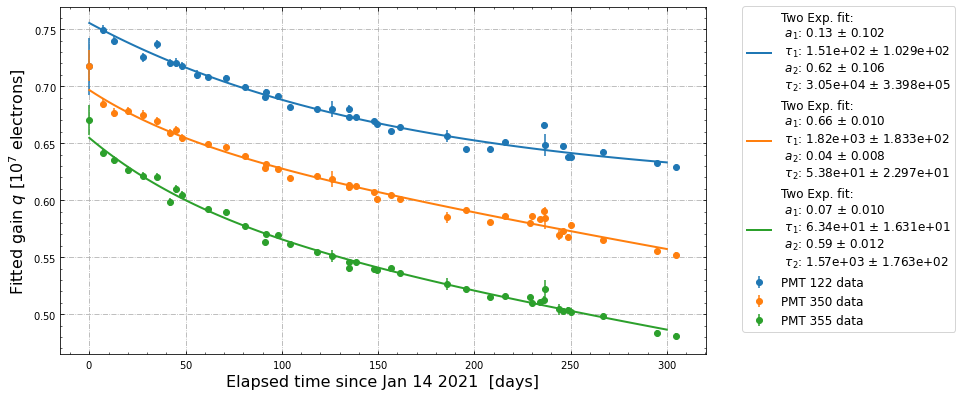

ALL DONE


In [ ]:
def expo(x, a, tau ):
    return a*np.exp( -x/tau) 

def fitcurve( x, y, ey ):
    params,pcov = curve_fit(expo, x, y, sigma=ey , p0=[ 0.75, 1075, ] )
    perrors = np.diag(pcov)**0.5

    return params, perrors
    
style=['solid', 'dashed']

fig, ax = plt.subplots(1,1, figsize=(10, 5.6))
tmin = np.min(data.index)

for PMT in [122, 350, 355] :   
        
        print(PMT)
                         
        # Get data
        SEL_PMT=data.pmt==PMT
        
        tmin = np.min(data[SEL_PMT].index)
        t = np.array([ (t-tmin) / (3600*24) for t in data[SEL_PMT].index ]) #in days
        q = np.array(data[SEL_PMT]["q"])
        eq = np.array(data[SEL_PMT]["eq"])
    

        out = ax.errorbar( x=t, y=q, yerr=eq, fmt='o', label="PMT %d data" % PMT)
        
        
        #fit segments 
        for i, trange in enumerate([ (0,100), (100,300) ]):
        
            sel=np.where( (t>=trange[0]) & (t<trange[1]) )
        
            params, perrors = fitcurve( t[sel], q[sel], eq[sel] )
            
            print(trange, params, perrors)
        
            time = np.linspace(trange[0], trange[1], 100)
            
            label='\n'.join( ['Exp. fit for range [%d:%d] days:' % (trange[0], trange[1]),
                              ' a: %.2f $\pm$ %.3f' % (params[0], perrors[0]),  
                              ' $\\tau$: %.2e $\pm$ %.3e' % (params[1], perrors[1]) 
                             ])
                        
            kargs = {'color':out[0].get_color(), 'lw':2, 'linestyle':style[i], 'label':label }
            
            ax.plot( time, [ expo( t, *params ) for t in time ], **kargs)
        
                    
        ax.set_ylabel("Fitted gain $q$ [$10^7$ electrons]", fontsize=16)
        ax.set_xlabel( "Elapsed time since %s  [days]" % datetime.fromtimestamp(tmin).strftime("%b %d %Y"), fontsize=16  )

        
fig.legend(fontsize=12, bbox_to_anchor=[1.34, 0.99])
plt.tight_layout()
plt.show()
        
        #pdf.savefig( fig )
        #plt.close(fig)
        

#pdf.close()

print("ALL DONE")

/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PMT 275 has no data associated


/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


PMT 357 has a failed fit for the range (100, 300)
ALL DONE


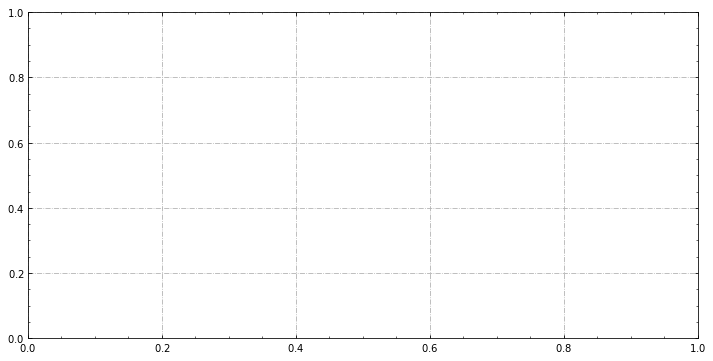

In [3]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("gain_fit_double_exp.pdf")

def expo(x, a, tau):
    return a*np.exp( -x/tau) 

def fitcurve( x, y, ey ):
    params,pcov = curve_fit(expo, x, y, sigma=ey , p0=[ 7.5, 10 ] )
    perrors = np.diag(pcov)**0.5
    
    return params, perrors
    

fit_params=[]

for PMT in range(360) :        
                     
        #print(PMT)
        
        # Get data
        SEL_PMT=data.pmt==PMT
    
        fig, ax = plt.subplots(1,1, figsize=(12, 6))
        tmin = np.min(data.index)
        
        tmin = np.min(data[SEL_PMT].index)
        t = np.array([ (t-tmin) / (3600*24) for t in data[SEL_PMT].index ]) #in days
        q = np.array(data[SEL_PMT]["q"])*10
        eq = np.array(data[SEL_PMT]["eq"])
        
        if len(q) ==0:
            print("PMT {} has no data associated".format(PMT))
            continue
    
        
        out = ax.errorbar( x=t, y=q, yerr=eq, fmt='o', label="Data PMT:%d" % PMT)
        
        
        #fit segments 
        for i, trange in enumerate([ (0,100), (100,300) ]):
        
            sel=np.where( (t>=trange[0]) & (t<trange[1]) )
            
            try:
                params, perrors = fitcurve( t[sel], q[sel], eq[sel] )
                
            except:
                print("PMT {} has a failed fit for the range {}".format(PMT, trange))
                continue
                
            fit_params.append( np.array([PMT, i, params[0], params[1], perrors[0], perrors[1]]) )
        
            time = np.linspace(trange[0], trange[1], 100)
            label='\n'.join( ['Exp. fit for range [%d:%d] days:' % (trange[0], trange[1]),
                              ' a: %.2f $\pm$ %.3f' % (params[0], perrors[0]),  
                              ' $\\tau$: %.2e $\pm$ %.3e' % (params[1], perrors[1]) 
                              ])
                        
            kargs = {'color':out[0].get_color(), 'lw':2, 'linestyle':style[i], 'label':label }
            ax.plot( time, [ expo( t, *params ) for t in time ], **kargs)
        
                    
        ax.set_ylabel("Fitted gain $q$ [$10^6$ electrons]", fontsize=16)
        ax.set_xlabel( "Elapsed time since %s  [days]" % datetime.fromtimestamp(tmin).strftime("%b %d %Y"), fontsize=16  )

        plt.legend(fontsize=16)
        plt.tight_layout()
        #plt.show()
        
        pdf.savefig( fig )
        plt.close(fig)
        

pdf.close()
print("ALL DONE")

params_array=np.array(fit_params)

336


ValueError: x and y must be the same size

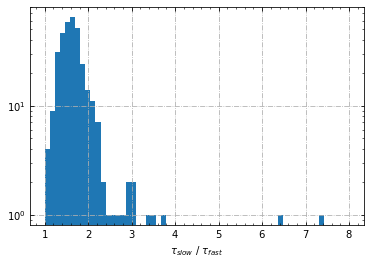

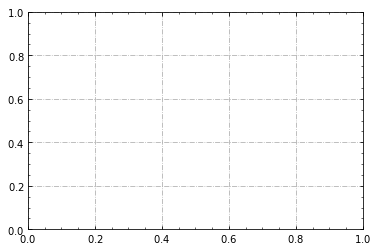

In [12]:
df=pd.DataFrame( { "channel_id":params_array[:,0], 
                   "range":params_array[:,1], 
                   "param_0":params_array[:,2], 
                   "param_1":params_array[:,3],
                   "error_param_0":params_array[:,4],
                   "error_param_1":params_array[:,5] }) 

dfs = df.groupby("channel_id").agg(list)


def _getratio(x):
    if len(x)==2:
        return x[1]/x[0]
    else:
        return -1
    

plt.figure(1)
dfs["ratio"] = dfs["param_1"].apply( lambda x : _getratio(x) )

print( len(dfs[ (dfs.ratio>1) & (dfs.ratio<8)].ratio) )

plt.hist(dfs["ratio"], range=(1, 8), bins=60)
plt.yscale("Log")
plt.xlabel( "$\\tau_{slow}$ / $\\tau_{fast}$" )


print(dfs[ dfs.param_1.apply( lambda x : np.any(  ) ) ]




plt.figure(2)

sel_ch=df.channel_id!=357
sel_par=(df.param_1 < 1e4) & (df.param_1 > 1e2) & (df.range==0)
dfc=df[sel_ch & sel_par]

plt.scatter( dfc[dfc.range==0].param_1, dfc[dfc.range==1].param_1 )
#plt.yscale("Log")
#plt.xscale("Log")

# MAKE A BOX with the total number of PMT Considered

plt.show()

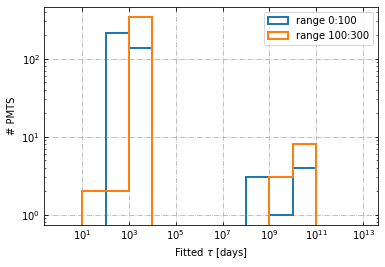

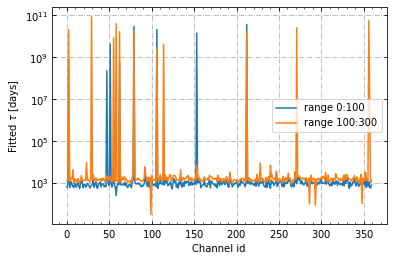

/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/icarus/app/users/ascarpel/env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


'\nplt.figure(2)\nplt.hist( df[df.range==0].param_1, histtype=\'step\', range=(1,1e5), bins=1000, label="range 0:100" )\nplt.hist( df[df.range==1].param_1, histtype=\'step\', range=(1,1e5), bins=1000, label="range 100:300" )\nplt.xscale("Log")\nplt.yscale("Log")\nplt.legend()\nplt.show()\n\nplt.figure(3)\nplt.hist( df[df.range==0].param_1, histtype=\'step\', range=(1e7,1e12), bins=1000, label="range 0:100" )\nplt.hist( df[df.range==1].param_1, histtype=\'step\', range=(1e7,1e12), bins=1000, label="range 100:300" )\nplt.xscale("Log")\nplt.yscale("Log")\nplt.legend()\nplt.show()\n'

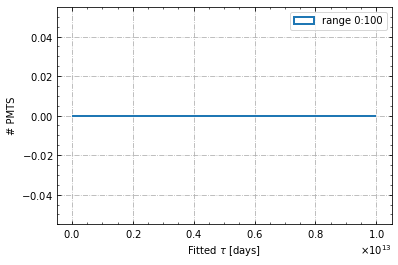

In [138]:




bins= [ np.power(10,i) for i in range(14) ] 

plt.figure(1)
plt.hist( df[df.range==0].param_1, bins=bins, histtype='step', lw=2.0, label="range 0:100" )
plt.hist( df[df.range==1].param_1, bins=bins, histtype='step', lw=2.0, label="range 100:300" )
plt.xscale("Log")
plt.yscale("Log")
plt.xlabel("Fitted $\\tau$ [days]")
plt.ylabel("# PMTS")
plt.legend()

# MAKE A BOX with the total number of PMT Considered

plt.show()


plt.figure(1)
plt.plot( df[df.range==0].channel_id, df[df.range==0].param_1, label="range 0:100" )
plt.plot( df[df.range==1].channel_id, df[df.range==1].param_1, label="range 100:300" )

plt.yscale("Log")
plt.ylabel("Fitted $\\tau$ [days]")
plt.xlabel("Channel id")
plt.legend()

# MAKE A BOX with the total number of PMT Considered

plt.show()

"""
plt.hist( df[df.range==1].param_1/df[df.range==0].param_1, bins=bins, histtype='step', lw=2.0, label="range 0:100" )
#plt.hist( , bins=bins, histtype='step', lw=2.0, label="range 100:300" )
#plt.xscale("Log")
#plt.yscale("Log")
plt.xlabel("Fitted $\\tau$ [days]")
plt.ylabel("# PMTS")
plt.legend()
"""

"""
plt.figure(2)
plt.hist( df[df.range==0].param_1, histtype='step', range=(1,1e5), bins=1000, label="range 0:100" )
plt.hist( df[df.range==1].param_1, histtype='step', range=(1,1e5), bins=1000, label="range 100:300" )
plt.xscale("Log")
plt.yscale("Log")
plt.legend()
plt.show()

plt.figure(3)
plt.hist( df[df.range==0].param_1, histtype='step', range=(1e7,1e12), bins=1000, label="range 0:100" )
plt.hist( df[df.range==1].param_1, histtype='step', range=(1e7,1e12), bins=1000, label="range 100:300" )
plt.xscale("Log")
plt.yscale("Log")
plt.legend()
plt.show()
"""

336


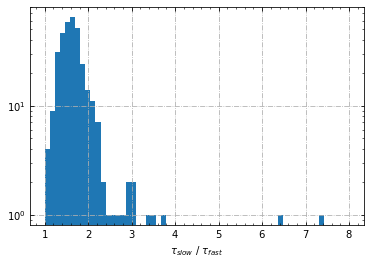